*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containng both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*



---



For this challenge, you will complete the code below to classify images of dogs and cats. You will use Tensorflow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. (Extra credit if you get it to 70% accuracy!)

Some of the code is given to you but some code you must fill in to complete this challenge. Read the instruction in each text cell so you will know what you have to do in each code cell.

The first code cell imports the required libraries. The second code cell downloads the data and sets key variables. The third cell is the first place you will write your own code.

The structure of the dataset files that are downloaded looks like this (You will notice that the test directory has no subdirectories and the images are not labeled):
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

You can tweak epochs and batch size if you like, but it is not required.

In [1]:
try:
# This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get project files
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# !unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Now it is your turn! Set each of the variables below correctly. (They should no longer equal `None`.)

Create image generators for each of the three image data sets (train, validation, test). Use `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. Use the `rescale` argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen` variables, use the `flow_from_directory` method. Pass in the batch size, directory, target size (`(IMG_HEIGHT, IMG_WIDTH)`), class mode, and anything else required. `test_data_gen` will be the trickiest one. For `test_data_gen`, make sure to pass in `shuffle=False` to the `flow_from_directory` method. This will make sure the final predictions stay is in the order that our test expects. For `test_data_gen` it will also be helpful to observe the directory structure.


After you run the code, the output should look like this:
```
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
```

In [3]:
# Generating image data
train_image_generator = ImageDataGenerator(rescale=1.0/255)
validation_image_generator = ImageDataGenerator(rescale=1.0/255)
test_image_generator = ImageDataGenerator(rescale=1.0/255)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=batch_size, class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=batch_size, class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
    PATH, batch_size=1, classes=['test'], target_size=(IMG_HEIGHT, IMG_WIDTH), shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional. This code is given to you. If you created the `train_data_gen` variable correctly, then running the cell below will plot five random training images.

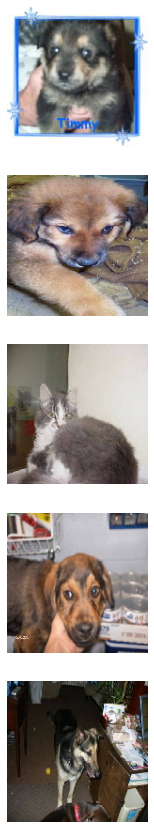

In [4]:
def plotImages(images_arr, prob=False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if not prob:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Recreate the `train_image_generator` using `ImageDataGenerator`. 

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

Add 4-6 random transformations as arguments to `ImageDataGenerator`. Make sure to rescale the same as before.


In [5]:
# augmenting train data
train_image_generator = ImageDataGenerator(
    rescale=1.0/255, 
    horizontal_flip=True, 
    brightness_range=[0.2,1.0], 
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
    )

You don't have to do anything for the next cell. `train_data_gen` is created just like before but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


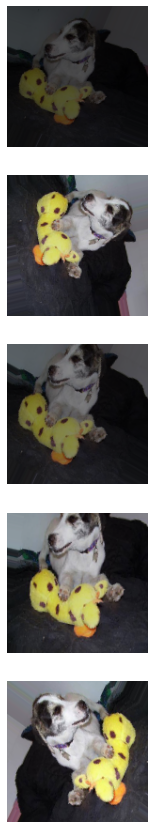

In [6]:
#Generating train data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In the cell below, create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

Compile the model passing the arguments to set the optimizer and loss. Also pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [7]:
# defining model architecture (baseline)
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [8]:
# testing model on sample input
model(sample_training_images)

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[0.49043825],
       [0.49242467],
       [0.4905161 ],
       [0.484946  ],
       [0.5008661 ],
       [0.48588488],
       [0.49526754],
       [0.48414752],
       [0.48084012],
       [0.49509656],
       [0.4895932 ],
       [0.47589278],
       [0.49017167],
       [0.49640107],
       [0.48598328],
       [0.4887777 ],
       [0.49624953],
       [0.48382643],
       [0.4926836 ],
       [0.48540768],
       [0.4835324 ],
       [0.48884484],
       [0.48393217],
       [0.4921493 ],
       [0.48703054],
       [0.4899793 ],
       [0.48163047],
       [0.4999808 ],
       [0.48923242],
       [0.4813993 ],
       [0.48035917],
       [0.48704013],
       [0.48330218],
       [0.47144857],
       [0.48976895],
       [0.4915846 ],
       [0.48640767],
       [0.4878175 ],
       [0.486905  ],
       [0.49807742],
       [0.49548918],
       [0.48564646],
       [0.48645222],
       [0.47948143],
       [0.4775643 ],
     

In [9]:
# defining model hyper-parameters
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4), 
              metrics=['accuracy'])

Use the `fit` method on your `model` to train the network. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

In [10]:
#Traing the network
history = model.fit(
    train_data_gen,
    steps_per_epoch=10,
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=val_data_gen,
    validation_steps=5
    )

Epoch 1/15
10/10 [==============================] - 15s 1s/step - loss: 0.6979 - accuracy: 0.5154 - val_loss: 0.6893 - val_accuracy: 0.5531
Epoch 2/15
10/10 [==============================] - 12s 1s/step - loss: 0.6887 - accuracy: 0.5625 - val_loss: 0.7165 - val_accuracy: 0.4844
Epoch 3/15
10/10 [==============================] - 12s 1s/step - loss: 0.6898 - accuracy: 0.5325 - val_loss: 0.6718 - val_accuracy: 0.5938
Epoch 4/15
10/10 [==============================] - 12s 1s/step - loss: 0.6782 - accuracy: 0.5984 - val_loss: 0.6671 - val_accuracy: 0.5875
Epoch 5/15
10/10 [==============================] - 12s 1s/step - loss: 0.6778 - accuracy: 0.5698 - val_loss: 0.6542 - val_accuracy: 0.6031
Epoch 6/15
10/10 [==============================] - 12s 1s/step - loss: 0.6746 - accuracy: 0.5787 - val_loss: 0.7214 - val_accuracy: 0.5234
Epoch 7/15
10/10 [==============================] - 12s 1s/step - loss: 0.6806 - accuracy: 0.5648 - val_loss: 0.6791 - val_accuracy: 0.5562
Epoch 8/15
10/10 [==

Run the next cell to visualize the accuracy and loss of the model.

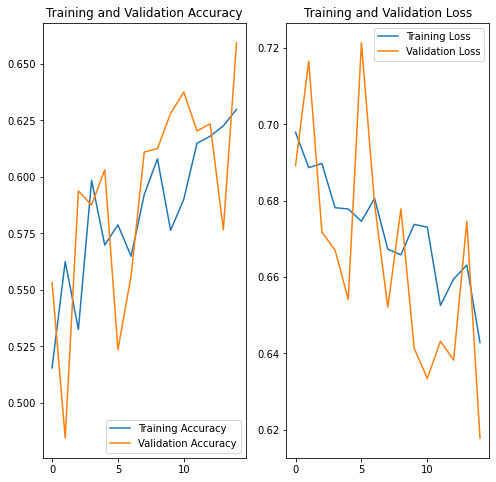

In [11]:
#Model Validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model overfits


In [23]:
# Apply dropout method
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)      

In [13]:
epochs=20

In [14]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=10,
    batch_size=batch_size, 
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=5
    )

Epoch 1/20
10/10 [==============================] - 13s 1s/step - loss: 0.6926 - accuracy: 0.5130 - val_loss: 0.6923 - val_accuracy: 0.4953
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 0.6930 - accuracy: 0.5055 - val_loss: 0.6902 - val_accuracy: 0.5016
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 0.6928 - accuracy: 0.5125 - val_loss: 0.6895 - val_accuracy: 0.5703
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss: 0.6908 - accuracy: 0.5544 - val_loss: 0.6863 - val_accuracy: 0.5094
Epoch 5/20
10/10 [==============================] - 12s 1s/step - loss: 0.6913 - accuracy: 0.5305 - val_loss: 0.6855 - val_accuracy: 0.5250
Epoch 6/20
10/10 [==============================] - 12s 1s/step - loss: 0.6904 - accuracy: 0.5430 - val_loss: 0.6854 - val_accuracy: 0.5078
Epoch 7/20
10/10 [==============================] - 12s 1s/step - loss: 0.6862 - accuracy: 0.5552 - val_loss: 0.6811 - val_accuracy: 0.5391
Epoch 8/20
10/10 [==

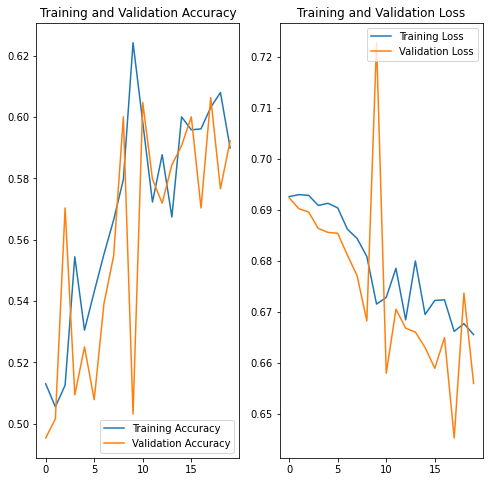

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this final cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` should be a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After your run the cell, you should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

In [16]:
# make prediction on test set
predictions = model.predict(test_data_gen)
predictions[:5]

array([[0.4030456 ],
       [0.25330907],
       [0.4239748 ],
       [0.6505062 ],
       [0.69837433]], dtype=float32)

In [17]:
# get array of predictions
probabilities = []
for i in predictions:
  probabilities.append(i[0])
probabilities[:5]

[0.4030456, 0.25330907, 0.4239748, 0.6505062, 0.69837433]

In [18]:
# get images array
test_images = []
for i in range(50):
  img, _ = next(test_data_gen)
  test_images.append(img[0])

In [19]:
test_images[0].shape

(150, 150, 3)

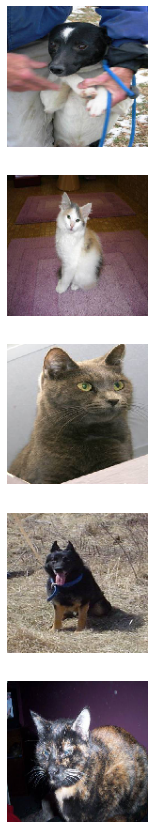

In [20]:
plotImages(test_images[:5])

In [21]:
# plot the probability that each test image is a dog or a cat
plotImages(test_images, prob=True)

Output hidden; open in https://colab.research.google.com to view.

Run this final cell to see if you passed the challenge or if you need to keep trying.

In [22]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.72% of the images of cats and dogs.
You passed the challenge!
